# Computer Vision Praktikum 3
## Building a CNN Face Recognition System 

#### Lorenc Zhuka & Patrick Eidemüller

In [1]:
from IPython.display import Image

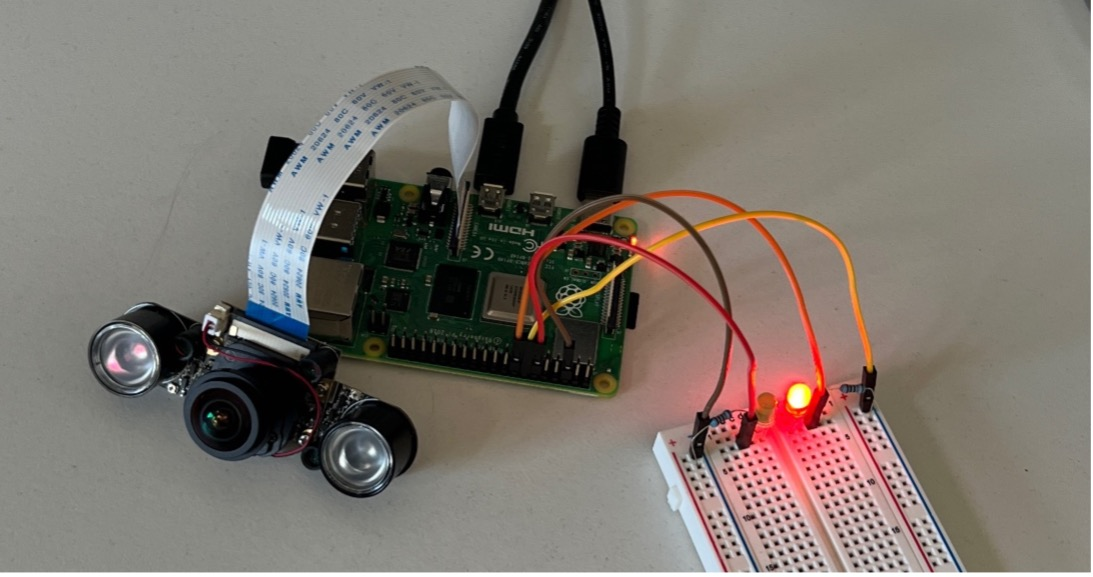

In [2]:
Image(filename='/Users/patrickeidemuller/Documents/Uni/MasterDataScience/2_CV/projekt/bilder präsi/facerecsystem.jpg')

### Table of Contents

* [1 Introduction and Picture Generation ](#1)
    * [1.1 Load Packages](#1.1)
    * [1.2 Generate Pictures](#1.2)
 
* [2 Data/Image Preprocessing](#2)
    * [2.1 Perform Random Sampling for each label](#2.1)
    * [2.2 Build the dataset with cropped images](#2.2)
       
* [3 CNN Model Selfmade](#3)
    * [3.1 Model Architecture](#3.1)
    * [3.2 Build, Compile & Save Model](#3.2)
    * [3.3 Score & metrics](#3.3)
    * [3.4 Live Stream Test](#3.4)
    
* [4 CNN Model Pre-trained](#4)
    * [4.1 Model Architecture](#4.1)
    * [4.2 Last Layer](#4.2)
    * [4.3 Score & metrics](#4.3)
    * [4.4 Live Stream Test](#4.4)
    
* [5 Transfer to Raspberry Pi](#5)
    * [5.1 Requirements](#5.1)
    * [5.2 Set up Raspberry](#5.2)
    * [5.3 Model.py on Raspberry](#5.3)
    * [5.4 Result](#5.4)
    
* [6 Resume](#5)  
    * [6.1 Fazit](#6.1)


### 1 Introduction <a class="anchor" id="1"></a>

#### 1.1 Load Packages <a class="anchor" id="1.1"></a>

In [1]:
# Überprüfen der Installation
import tensorflow as tf
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot  as plt
from PIL import Image
from pathlib import Path
import imagesize
import random

# Ausgeben der Version
tf.__version__

'2.8.0'


#### 1.2 Generate Pictures <a class="anchor" id="1.2"></a>

In [ ]:
# WITH LIVE CAMERA TO GENERATE AND SAVE PICTURES
import cv2

# Connects to your computer's default camera
cap = cv2.VideoCapture(0)


# Automatically grab width and height from video feed
# (returns float which we need to convert to integer for later on!)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
bilder = []


while True:
    
    # Capture frame-by-frame
    ret, frame = cap.read()
    bilder.append(frame)
    
    # Display the resulting frame
    cv2.imshow('frame',frame)
    
    # This command let's us quit with the "q" button on a keyboard.
    # Simply pressing X on the window won't work!
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything done, release the capture and destroy the windows
cap.release()
cv2.destroyAllWindows()

Save the pictures of each label inside a specific folder. In this example Patrick's images are saved into Patrick's folder.

In [22]:
from PIL import Image as im


for i in range(len(bilder)):
     data = im.fromarray(bilder[i])
     data.save("datasets/patrick/patrick_mv" + str(i) +'.png')

### 2 Data/Image Processing <a class="anchor" id="1"></a>


Create a python dictionary with the image paths.

In [23]:
from pathlib import Path

data = {}
for label in ['patrick', 'lorenc', 'andere']:
    imgs = ['datasets/' + label + '/' + img.name for img in Path('datasets/' + label).iterdir() if img.suffix == ".JPG" or img.suffix=='.png' or 
                                                                       img.suffix=='.jpeg' or img.suffix=='.jpg' or 
                                                                       img.suffix=='.PNG']
    data[label] = imgs

Print the number of images for each label

In [24]:
for key in data.keys():
    print(f"Label : {key}")
    print(f"Length : {len(data[key])}")
    print()

Label : patrick
Length : 1850

Label : lorenc
Length : 1580

Label : andere
Length : 7219



#### 2.1 Perform Random Sampling for each label  <a class="anchor" id="2.1"></a>

In [25]:
import random

for key in data.keys():
    if key == 'lorenc':
        data[key] = random.sample(data[key], 500)
    elif key == 'patrick':
        data[key] = random.sample(data[key], 500)
    else:
        data[key] = random.sample(data[key], 1500)

#### 2.2 Build the datasets with cropped images <a class="anchor" id="2.2"></a>
(Ausgeklammert, da es sehr viel Zeit kostet mit mtcnn die Gesichter aus den Bildern zu schneiden)

In [26]:
# from matplotlib import pyplot
# from matplotlib.patches import Rectangle
# from matplotlib.patches import Circle
# from mtcnn.mtcnn import MTCNN

# X_one_channel = []
# X_three_channels = []
# y = []

# img_width = 400
# img_height = 500
# face_width = 200
# face_height = 400

# face_widths = []
# face_heights = []

# nr_images_no_face_found = {'patrick' : 0, 'lorenc' : 0, 'andere' : 0}
# nr_images_face_error_shape = {'patrick' : 0, 'lorenc' : 0, 'andere' : 0}


# for label in data.keys():    
#     numpy_arrays_one_channel = []
#     numpy_arrays_three_channels = []

#     for i in range(len(data[label])):
#         filename = data[label][i]
#         img = cv2.imread(filename)
#         img = cv2.resize(img, (img_width, img_height))
#         detector = MTCNN()
        
#         faces = detector.detect_faces(img)
#         if faces == []:
#             nr_images_no_face_found[label] += 1
        
#         else:
#             x1, y1, width, height = faces[0]['box']
#             x1 = x1-25
#             y1 = y1-100 
#             width = width+50
#             height = height+150
#             face_widths.append(width)
#             face_heights.append(height)
            
#             x2, y2 = x1 + width, y1 + height
#             face_img = img[y1:y2, x1:x2]
#             if face_img.shape[0] == 0 or face_img.shape[1] == 0 or face_img.shape[2] == 0:
#                 nr_images_face_error_shape[label] += 1
#                 #print('Error Img')
#             else:
    
#                 resized_face = cv2.resize(face_img, (face_width, face_height))
#                 #plt.imshow(resized_face, cmap='gray')
#                 #plt.show()

#                 face_img_three_channels = resized_face
#                 #print(face_img_three_channels.shape)

#                 face_img_one_channel = np.expand_dims(cv2.cvtColor(resized_face, cv2.COLOR_BGR2GRAY), axis=-1)
#                 #print(face_img_one_channel.shape)

#                 numpy_arrays_one_channel.append(face_img_one_channel)
#                 numpy_arrays_three_channels.append(face_img_three_channels)
    
#     print(len('Finish Loop'))
#     X_one_channel = X_one_channel + numpy_arrays_one_channel
#     X_three_channels = X_three_channels + numpy_arrays_three_channels

#     new_label = label + ' ' 
#     y = y + (new_label * len(numpy_arrays_one_channel)).split()

In [27]:
import numpy as np
import cv2
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from matplotlib.patches import Circle
from mtcnn.mtcnn import MTCNN

full_width = 400
full_height = 400
y_full = []
X_full_numpy_arrays_one_channel = []
X_full_numpy_arrays_three_channels = []

for label in data.keys():    
    numpy_arrays_one_channel = []
    numpy_arrays_three_channels = []

    for i in range(len(data[label])):
        filename = data[label][i]
        img = cv2.imread(filename)
        new_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # gray filter
        resized_img = cv2.resize(new_img, (full_width, full_height)) #resize picture 
        resized_img = np.expand_dims(resized_img, axis=-1)
        
        resized_img_three = cv2.resize(img, (full_width, full_height))
        
        numpy_arrays_one_channel.append(resized_img) 
        numpy_arrays_three_channels.append(resized_img_three)
    
    X_full_numpy_arrays_one_channel = X_full_numpy_arrays_one_channel + numpy_arrays_one_channel
    X_full_numpy_arrays_three_channels = X_full_numpy_arrays_three_channels + numpy_arrays_three_channels
    
    new_label = label + ' ' 
    y_full = y_full + (new_label * len(numpy_arrays_one_channel)).split()

In [28]:
X_full_numpy_arrays_one_channel[1].shape, X_full_numpy_arrays_three_channels[1].shape

((400, 400, 1), (400, 400, 3))

Convert python lists to numpy array

In [29]:
X_full_numpy_arrays_one_channel = np.array(X_full_numpy_arrays_one_channel).reshape(len(X_full_numpy_arrays_one_channel), X_full_numpy_arrays_one_channel[0].shape[0], X_full_numpy_arrays_one_channel[0].shape[1], 1)
X_full_numpy_arrays_three_channels = np.array(X_full_numpy_arrays_three_channels).reshape(len(X_full_numpy_arrays_three_channels), X_full_numpy_arrays_three_channels[0].shape[0], X_full_numpy_arrays_three_channels[0].shape[1], 3)

In [30]:
X_full_numpy_arrays_one_channel[1].shape, X_full_numpy_arrays_three_channels[1].shape

((400, 400, 1), (400, 400, 3))

In [31]:
print(X_full_numpy_arrays_one_channel.shape)
print(X_full_numpy_arrays_three_channels.shape)

(2500, 400, 400, 1)
(2500, 400, 400, 3)


In [32]:
y_full = np.array(y_full)
print(y_full.shape)

(2500,)


Shuffle the images

In [33]:
from sklearn.utils import shuffle

shuffled_X_full_one_channel, shuffled_y_full_one = shuffle(X_full_numpy_arrays_one_channel, y_full, random_state=0)
shuffled_X_full_three_channels, shuffled_y_full_three = shuffle(X_full_numpy_arrays_three_channels, y_full, random_state=0)

Perform train test split to avoid overfitting

In [34]:
from sklearn.model_selection import train_test_split

X_train_full_one_channel, X_test_full_one_channel, y_train_full_one_channel, y_test_full_one_channel = train_test_split(shuffled_X_full_one_channel, shuffled_y_full_one,
                                                                    stratify=shuffled_y_full_one,
                                                                    random_state=0, test_size=0.2)

X_train_full_three_channels, X_test_full_three_channels, y_train_full_three_channels, y_test_full_three_channels = train_test_split(shuffled_X_full_three_channels, shuffled_y_full_three,
                                                                    stratify=shuffled_y_full_three,
                                                                    random_state=0, test_size=0.2)

Scale the image pixels in a range from 0 to 1 in order to make the gradient descent converge faster.

In [35]:
import tensorflow as tf
import numpy as np

tf.keras.backend.set_floatx('float64')

# Setzen des Seeds - Zur Reproduktion, da die initalen Gewichte zufällig gesetzt werden
np.random.seed(42)
tf.random.set_seed(32)

X_train_full_one_channel = X_train_full_one_channel / 255
X_test_full_one_channel = X_test_full_one_channel / 255

X_train_full_three_channels = X_train_full_three_channels / 255
X_test_full_three_channels = X_test_full_three_channels / 255

Save the label as Pandas Dataframes for easier manipulation

In [36]:
import pandas as pd

y_train_full_one_channel = pd.DataFrame({'label' : y_train_full_one_channel})
y_train_full_one_channel['label'] = y_train_full_one_channel['label'].map({'andere' : 0, 'patrick' : 1, 'lorenc' : 2})
y_test_full_one_channel = pd.DataFrame({'label' : y_test_full_one_channel})
y_test_full_one_channel['label'] = y_test_full_one_channel['label'].map({'andere' : 0, 'patrick' : 1, 'lorenc' : 2})

y_train_full_three_channels = pd.DataFrame({'label' : y_train_full_three_channels})
y_train_full_three_channels['label'] = y_train_full_three_channels['label'].map({'andere' : 0, 'patrick' : 1, 'lorenc' : 2})
y_test_full_three_channels = pd.DataFrame({'label' : y_test_full_three_channels})
y_test_full_three_channels['label'] = y_test_full_three_channels['label'].map({'andere' : 0, 'patrick' : 1, 'lorenc' : 2})



Build the CNN model using Conv2D, Maxpoolind2D and Dense Layers.

In [41]:
import tensorflow 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split

def build_model():
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=X_train_full_one_channel.shape[1:]))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))

    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))


    model.add(Dense(units=3, activation = 'softmax'))
    
    # we must use sparse_categorical_crossentropy since we have not encoded the target feature into one hot features
    model.compile(loss ='sparse_categorical_crossentropy', optimizer=Adam(lr=0.001),metrics='accuracy')
    
    return model

#### 3.2 Build, Compile & Save Model  <a class="anchor" id="2.2"></a>

In [42]:
import tensorflow as tf

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.85):
            print("\nReached 85.0% accuracy so cancelling training!")
            self.model.stop_training = True

    def on_train_batch_end(self, batch, logs=None):
        if(logs.get('accuracy') > 0.85):
            print("\nReached 85.0% accuracy so cancelling training!")
            self.model.stop_training = True 


        
callback = myCallback()


callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model = build_model()
model_history = model.fit(X_train_full_one_channel, 
                          y_train_full_one_channel, 
                          validation_data=(X_test_full_one_channel, y_test_full_one_channel), 
                          epochs=100, batch_size=18, callbacks=[callback], verbose=True)

C:\Users\loriz\Anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
112/112 [==============================] - 442s 4s/step - loss: 0.7415 - accuracy: 0.8020 - val_loss: 0.1215 - val_accuracy: 0.9620
Epoch 2/100
 28/112 [======>.......................] - ETA: 4:59 - loss: 0.1433 - accuracy: 0.9544

KeyboardInterrupt: 

In [43]:
model.save('cnn_new_model.h5')

In [49]:
# from tensorflow import keras
# model = keras.models.load_model('cnn_new_model.h5')

#### 3.3 Metrics & Accuracy  <a class="anchor" id="2.3"></a>

In [45]:
test_pred = np.argmax(model.predict(X_test_full_one_channel), axis=1)

In [46]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test_full_one_channel, test_pred)

array([[300,   0,   0],
       [ 10,  90,   0],
       [  7,   2,  91]], dtype=int64)

In [47]:
from sklearn.metrics import classification_report

print(classification_report(test_pred, y_test_full_one_channel))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97       317
           1       0.90      0.98      0.94        92
           2       0.91      1.00      0.95        91

    accuracy                           0.96       500
   macro avg       0.94      0.97      0.95       500
weighted avg       0.97      0.96      0.96       500



#### 3.4 Live Stream Test  <a class="anchor" id="2.4"></a>

In [2]:
## TEST MODEL USING LIVE CAMERA

import cv2
import numpy as np
from tensorflow import keras
import tensorflow as tf

model = keras.models.load_model('cnn_new_model.h5')

full_width = 400
full_height = 400

# Connects to your computer's default camera
cap = cv2.VideoCapture(0)
        
label_dic = {0 : 'andere' , 1 : 'patrick', 2 : 'lorenc'}

while True:
    
    # Capture frame-by-frame
    ret, frame = cap.read()
    new_img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    resized_img = cv2.resize(new_img, (full_width, full_height))
    resized_img = np.expand_dims(resized_img, axis=-1)
    resized_img = np.expand_dims(resized_img, axis=0)
    resized_img = resized_img / 255
    predictions = model(resized_img).numpy()
    probs = tf.nn.softmax(predictions).numpy()
    cv2.putText(frame, f"Prediction : {label_dic[np.argmax(probs[0])]}", (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2, cv2.LINE_AA)

    # Display the resulting frame
    cv2.imshow('frame',frame)#live cam oder frame 
    
    # This command let's us quit with the "q" button on a keyboard.
    # Simply pressing X on the window won't workq!
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything done, release the capture and destroy the windows
cap.release()
cv2.destroyAllWindows()

### 4 CNN Model Pre-trained <a class="anchor" id="3"></a>

#### 4.1 Model Architecture  <a class="anchor" id="3.1"></a>

We are going to use VGG16 model which was pretrained using imagenet dataset and freeze the weights of this model's layers to avoid large computational and training time.

In [54]:
X_train_full_three_channels.shape

(2000, 400, 400, 3)

In [55]:
from tensorflow.keras.applications import VGG16

# include_top=False to not include last fully connected layer (output layer)
# we must specify the shape of our images
pre_trained_model = VGG16(input_shape=X_train_full_three_channels.shape[1:], 
                          include_top=False, weights='imagenet')

for layer in pre_trained_model.layers:
    layer.trainable = False

    
pre_trained_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 400, 400, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 400, 400, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 400, 400, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 200, 200, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 200, 200, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 200, 200, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 100, 100, 128)     0     

#### 4.2 Train last layer  <a class="anchor" id="3.2"></a>

In [56]:
last_layer = pre_trained_model.get_layer('block5_pool')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output
print(last_output)

last layer output shape:  (None, 12, 12, 512)
KerasTensor(type_spec=TensorSpec(shape=(None, 12, 12, 512), dtype=tf.float64, name=None), name='block5_pool/MaxPool:0', description="created by layer 'block5_pool'")


Add some Dense Layers which are going to be trained and a Dropout Layer to avoid overfitting.

In [57]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import layers
from tensorflow.keras import Model

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)                  
x = layers.Dense(3, activation='softmax')(x)           

model_transfer_learning = Model(pre_trained_model.input, x) 

model_transfer_learning.compile(loss ='sparse_categorical_crossentropy', optimizer=Adam(lr=0.001), 
              metrics = ['accuracy'])

model_transfer_learning.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 400, 400, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 400, 400, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 400, 400, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 200, 200, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 200, 200, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 200, 200, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 100, 100, 128)     0     

C:\Users\loriz\Anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Traing the pretrained model using only the added layers.

In [58]:
model_history = model_transfer_learning.fit(X_train_full_three_channels, y_train_full_three_channels,
                                            validation_data=(X_test_full_three_channels, y_test_full_three_channels),
                                            epochs=2, batch_size=18, verbose=True)

Epoch 1/2
 99/112 [=========================>....] - ETA: 6:44 - loss: 0.6406 - accuracy: 0.9130

KeyboardInterrupt: 

In [61]:
model_transfer_learning.save('new_pretrained.h5')

#### 4.3 Score & metrics  <a class="anchor" id="3.3"></a>

In [62]:
test_pred = np.argmax(model_transfer_learning.predict(X_test_full_three_channels), axis=1)

In [63]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test_full_three_channels, test_pred)

array([[299,   0,   1],
       [  0, 100,   0],
       [  0,   0, 100]], dtype=int64)

In [65]:
from sklearn.metrics import classification_report

print(classification_report(y_test_full_three_channels, test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       300
           1       1.00      1.00      1.00       100
           2       0.99      1.00      1.00       100

    accuracy                           1.00       500
   macro avg       1.00      1.00      1.00       500
weighted avg       1.00      1.00      1.00       500



#### 4.4 Live Stream Test  <a class="anchor" id="3.4"></a>

In [3]:
## TEST MODEL USING LIVE CAMERA

import cv2
import numpy as np
from tensorflow import keras
import tensorflow as tf

model = keras.models.load_model('new_pretrained.h5')

full_width = 400
full_height = 400

# Connects to your computer's default camera
cap = cv2.VideoCapture(0)
        
label_dic = {0 : 'andere' , 1 : 'patrick', 2 : 'lorenc'}

while True:
    
    # Capture frame-by-frame
    ret, frame = cap.read()
    resized_img = cv2.resize(frame, (full_width, full_height))
    resized_img = np.expand_dims(resized_img, axis=-1)
    resized_img = np.expand_dims(resized_img, axis=0)
    resized_img = resized_img / 255
    predictions = model(resized_img).numpy()
    probs = tf.nn.softmax(predictions).numpy()
    cv2.putText(frame, f"Prediction : {label_dic[np.argmax(probs[0])]}", (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2, cv2.LINE_AA)

    # Display the resulting frame
    cv2.imshow('frame',frame)#live cam oder frame 
    
    # This command let's us quit with the "q" button on a keyboard.
    # Simply pressing X on the window won't workq!
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything done, release the capture and destroy the windows
cap.release()
cv2.destroyAllWindows()

### 5 Transfer to Raspberry Pi <a class="anchor" id="4"></a>

#### 5.1 Requirements  <a class="anchor" id="4.1"></a>

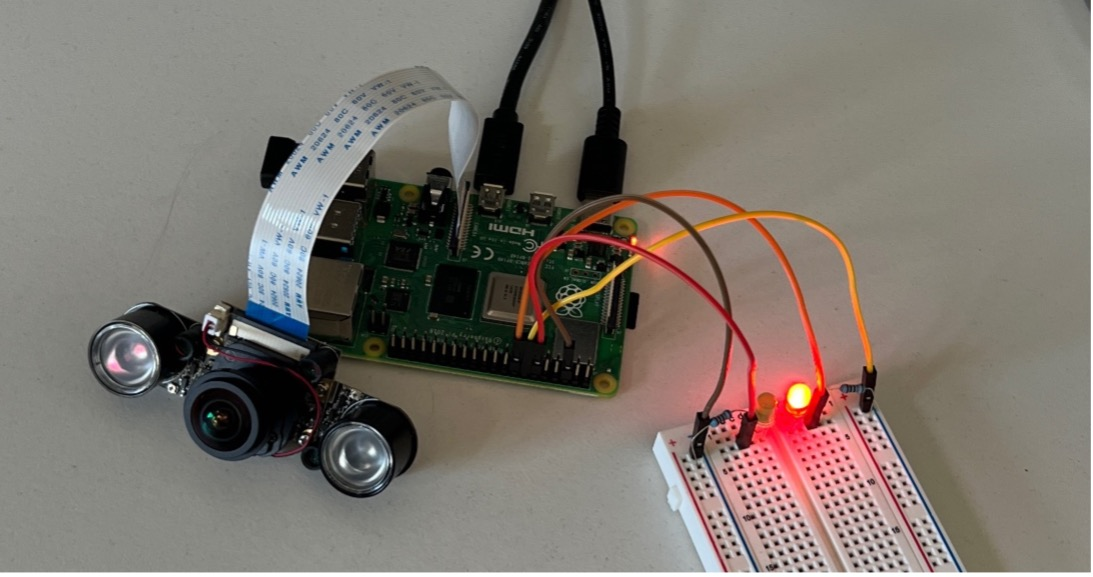

In [4]:
Image(filename='/Users/patrickeidemuller/Documents/Uni/MasterDataScience/2_CV/projekt/bilder präsi/facerecsystem.jpg')

##### Hardware
- Raspberry Pi
- SD-Card
- Jumpwire
- LED´s
- Electrical resistance 
- breadboard
- Camera

##### Software 

- flash Raspbian to SD-Card
- set up wlan & ssh
- set up environment and install packages
- load model via ssh to Pi
- create skript to run model and light the LED´s
- activate Camera 

#### 5.2 Set-up the Raspberry Pi  <a class="anchor" id="4.1"></a>

1. Download Raspbian and flash on SD-Card (activate yoour local network before you start the flash process). Insert SD-Card in Pi and wait. 

2. Find out IP-Adress of Pi in your Networksettings to connect via ssh (ssh pi@ip-adress)to your pi. Select username and password for futher log in. 

3. Activate Camera type in the command line: sudo raspi-config and a settings window will open. Follow the following path to activate the camera: > interfacing options > enable camera > reboot. Test with vcgencmd get_camera. If supported & detected = 1 everything is okay. 

4. Connect more than one network in our case eduram. Open interfaces with typing the following path into the terminal: sudo nano /etc/network/interfaces. Make sure that the following 2 lines are in the file:
- iface wlan0 inet manual
- wpa-roam /etc/wpa_supplicant/wpa_supplicant.conf
Complement the following 2 lines: 
- iface netzwerk_a inet dhcp
- iface netzwerk_b inet dhcp

Now open the supplicant.conf file to add the network. sudo nano /etc/wpa_supplicant/wpa_supplicant.conf and add the following information for the network. Add the id to the existing network as well

network={
ssid="eduroam"
proto=RSN
key_mgmt=WPA-EAP
eap=PEAP
identity=„stpaeide“
password=„xxx“
phase1="peaplabel=0"
phase2="auth=MSCHAPV2"
id_str="netzwerk_b“
}

5. Set up Virtual Environment and install packages. Create project folder CV with mkdir CV. For setting up the virtual environment install the packages virtualenv with sudo pip3 install virtualenv. Then create env with virtualenv -p python3 .venv. Now activate the env with source env/bin/activate and install the following packages: 

- pip3 install jupyter
- Pip3 install matplotlib
- pip3 install pandas
- pip3 install numpy
- pip install opencv-python
- Pip install pathlib
- Pip install mtcnn 
- pip install scikit-learn
- Pip install imagesize 
- pip install RPi.GPIO :ssh GPIO controlling 


6. installing tensorflow on raspberry is kind of difficult. Look up the right version with the following link : https://github.com/PINTO0309/Tensorflow-bin/tree/main/previous_versions. With wget and the raw link you can download the tensorflow wheel: wget https://raw.githubusercontent.com/PINTO0309/Tensorflow-bin/main/previous_versions/download_tensorflow-2.8.0-cp39-none-linux_aarch64_numpy1221.sh. With sudo chmod +x download_tensorflow-2.8.0-cp39-none-linux_aarch64_numpy1221.sh you can install tensorflow on the raspberry.

7. Create a script with the code from 5.3 to activate the camera, run the model and light the led´s 
8. Transfer the model to the project folder with:
- scp path/on/computer/model.h5 pi@ip:/home/pi/projectfolder
9. Build the circuit. Connect the jumpwire to a pin with a number for example number 18, plug in the led in a column with a letter but one end in the same row as the jumpwire. Use a restiance to connect the green led on the other side with the next jumpwire wich is connected to the raspberry with a pin with the label gnd and plugged in in the breadboard on the minus column. To the same for the number 23 with a red led. 

9. run the script

#### 5.3 Run Model on Rasbperry  <a class="anchor" id="4.2"></a>

In [ ]:
## TEST MODEL USING LIVE CAMERA on RASPBERRY PI

import cv2
import numpy as np
from tensorflow import keras
import tensorflow as tf
import RPi.GPIO as GPIO
import time

model = keras.models.load_model('model_selfmade.h5')

full_width = 400
full_height = 400

# Connects to your computer's default camera
cap = cv2.VideoCapture(0)
        
label_dic = {0 : 'andere' , 1 : 'patrick', 2 : 'lorenc'}

while True:
    
    # Capture frame-by-frame
    ret, frame = cap.read()
    new_img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    resized_img = cv2.resize(new_img, (full_width, full_height))
    resized_img = np.expand_dims(resized_img, axis=-1)
    resized_img = np.expand_dims(resized_img, axis=0)
    print(resized_img.shape)
    resized_img = resized_img / 255
    predictions = model(resized_img).numpy()
    probs = tf.nn.softmax(predictions).numpy()
    cv2.putText(frame, f"Prediction : {label_dic[np.argmax(probs[0])]}", (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2, cv2.LINE_AA)
    
    if label_dic[np.argmax(probs[0])] == "andere":
        GPIO.setmode(GPIO.BCM)
        GPIO.setwarnings(False)
        GPIO.setup(23,GPIO.OUT)
        print "LED on"
        GPIO.output(23,GPIO.HIGH)
        time.sleep(3)
        print "LED off"
        GPIO.output(23,GPIO.LOW)
        
    if label_dic[np.argmax(probs[0])] == "patrick":
            GPIO.setmode(GPIO.BCM)
            GPIO.setwarnings(False)
            GPIO.setup(18,GPIO.OUT)
            print "LED on"
            GPIO.output(18,GPIO.HIGH)
            time.sleep(3)
            print "LED off"
            GPIO.output(18,GPIO.LOW)
            
    if label_dic[np.argmax(probs[0])] == "lorenc":
            GPIO.setmode(GPIO.BCM)
            GPIO.setwarnings(False)
            GPIO.setup(18,GPIO.OUT)
            print "LED on"
            GPIO.output(18,GPIO.HIGH)
            time.sleep(3)
            print "LED off"
            GPIO.output(18,GPIO.LOW)
            
    else:
        continue 

    # Display the resulting frame
    cv2.imshow('frame',frame)#live cam oder frame 
    
    # This command let's us quit with the "q" button on a keyboard.
    # Simply pressing X on the window won't workq!
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything done, release the capture and destroy the windows
cap.release()
cv2.destroyAllWindows()

#### 5.4 Result <a class="anchor" id="4.3"></a>

As you can see in the picture below is that the system works quiete well with the new camera without wide angel.

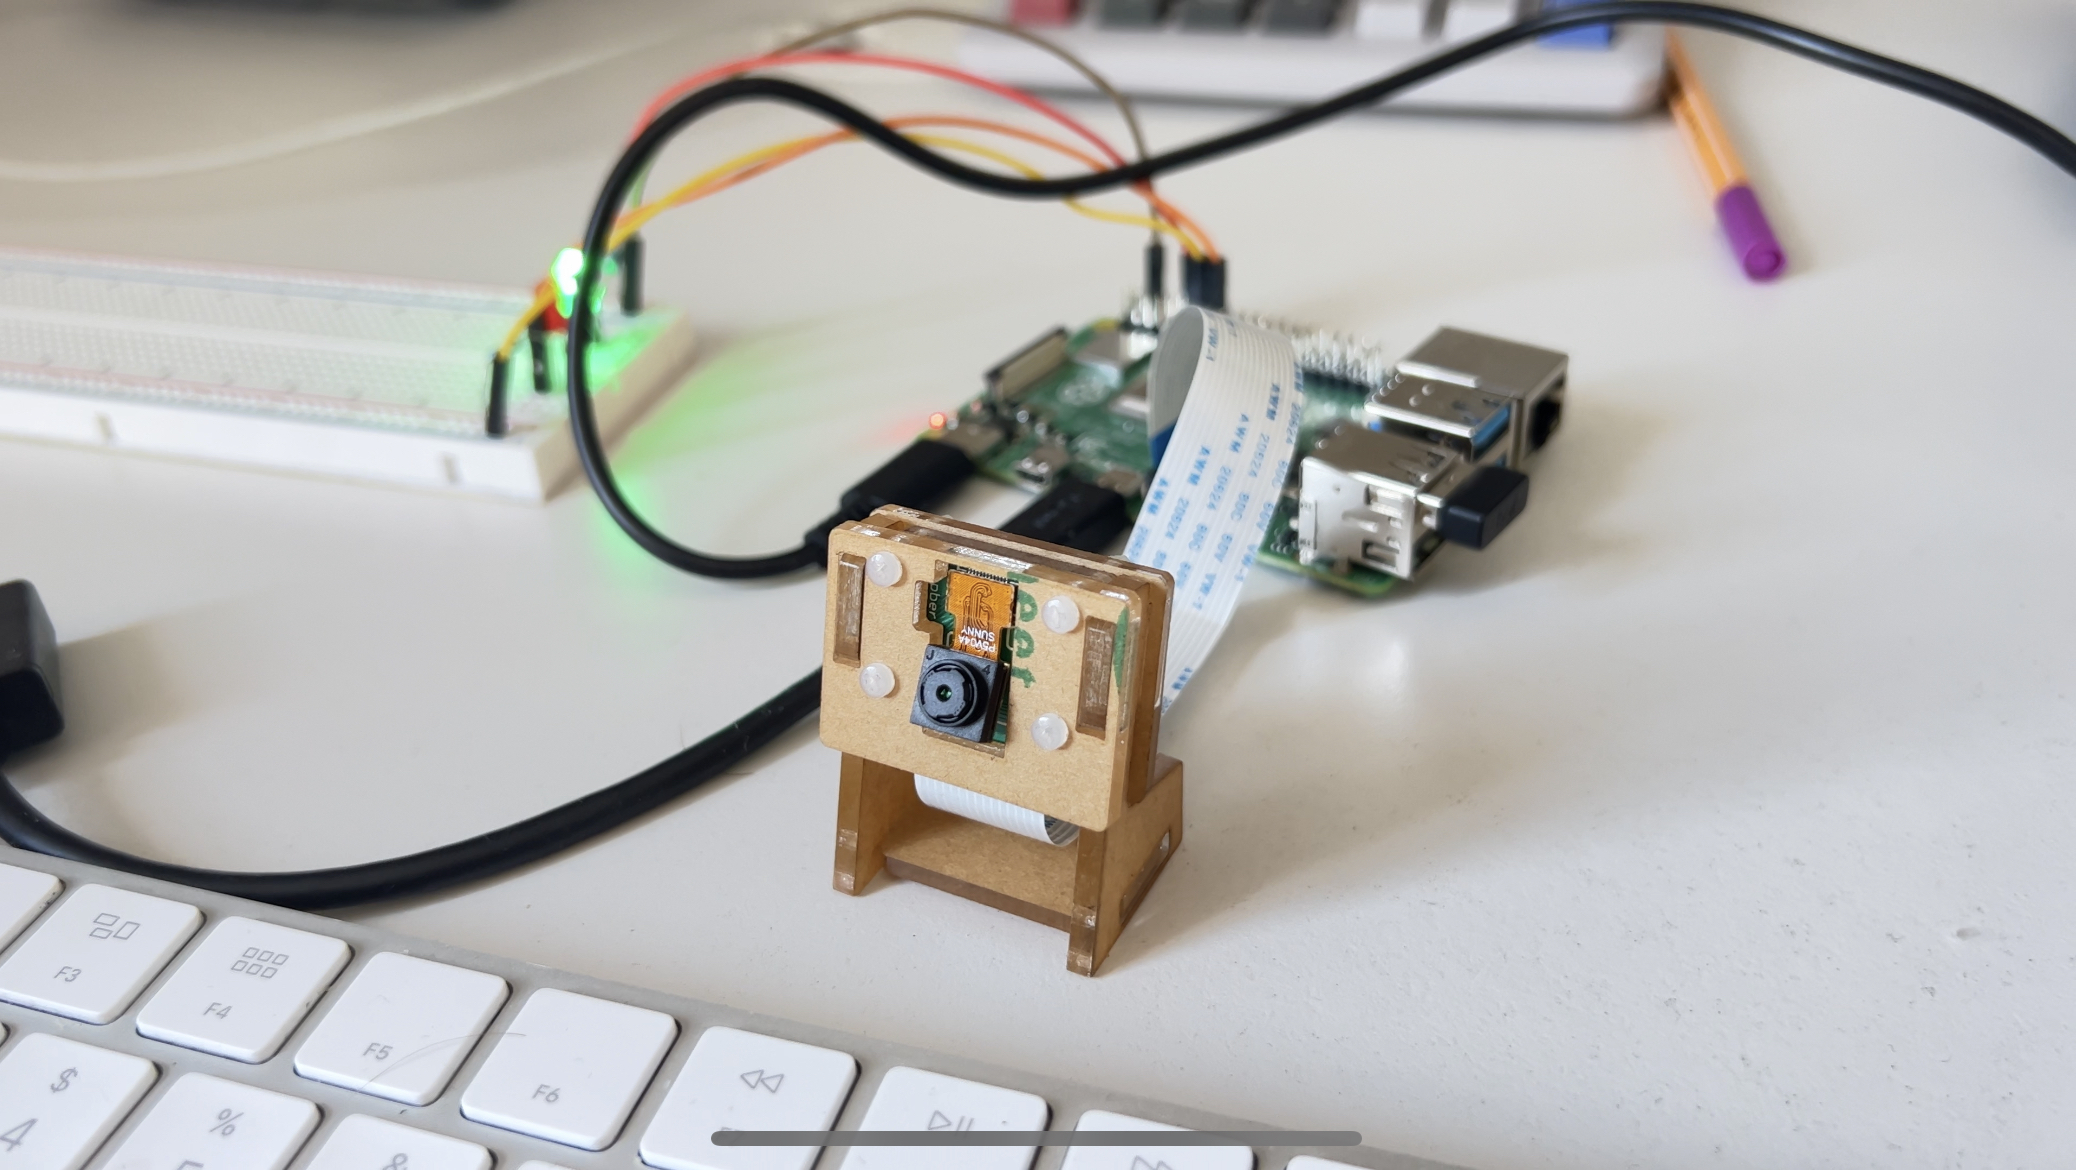

In [3]:
Image(filename='/Users/patrickeidemuller/Documents/Uni/MasterDataScience/2_CV/projekt/bilder präsi/funktionierendes system.jpg')

### 6 Resume <a class="anchor" id="5"></a>

#### 6.1 Fazit  <a class="anchor" id="5.1"></a>

- most impact have the quality of the pictures for training the model in terms of lighting, angel and background variety 
- pre-trained models are more efficient and easier to use 
- the score and false-positiv rate is surprisingly good
- there need to be more specific test with faces similar to the person who should be identified to check the security of the system. Also with pictures of them to verify if the system can be tricked out with pictures.